In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
from copy import copy
import datetime

import seaborn as sb
import matplotlib.pyplot as plt

import tensorflow as tf

# Data Preprocessing

In [2]:
sales = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv',
                          dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'}, 
                          parse_dates=['date'],infer_datetime_format=True)

In [3]:
sales.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
sales.store_nbr.nunique(), sales.family.nunique(),  sales.date.nunique()

(54, 33, 1684)

In [5]:
# Find the total sales per day
total_sales = sales.groupby('date').sum().squeeze()
total_sales = total_sales.reindex(pd.date_range(datetime.datetime(2013,1,1), datetime.datetime(2017,8,15), freq='D'), fill_value=0)

In [6]:
total_sales.head()

,id,sales,onpromotion
2013-01-01,1586871,2511.618896,0
2013-01-02,4762395,496092.406250,0
2013-01-03,7937919,361461.218750,0
2013-01-04,11113443,354459.687500,0
2013-01-05,14288967,477350.125000,0


In [7]:
# function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Date")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [8]:
df = pd.DataFrame({
    'date': total_sales.index,
    'value': total_sales['sales']
})

In [9]:
df.head()

,date,value
2013-01-01,2013-01-01,2511.618896
2013-01-02,2013-01-02,496092.406250
2013-01-03,2013-01-03,361461.218750
2013-01-04,2013-01-04,354459.687500
2013-01-05,2013-01-05,477350.125000


In [10]:
df.shape

(1688, 2)

In [11]:
X = df['date']
y = df['value']

split_size = int(0.8 * len(X))

X_train, y_train = X[:split_size], y[:split_size]
X_val, y_val = X[split_size:], y[split_size:]

len(X_train), len(X_val), len(y_train), len(y_val)

(1350, 338, 1350, 338)

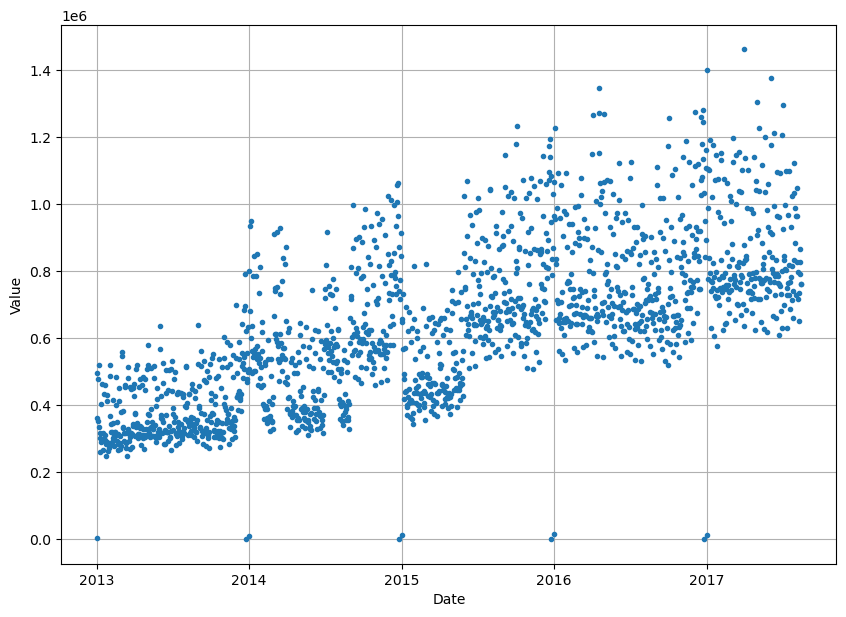

In [12]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=df['date'], values=df['value'])

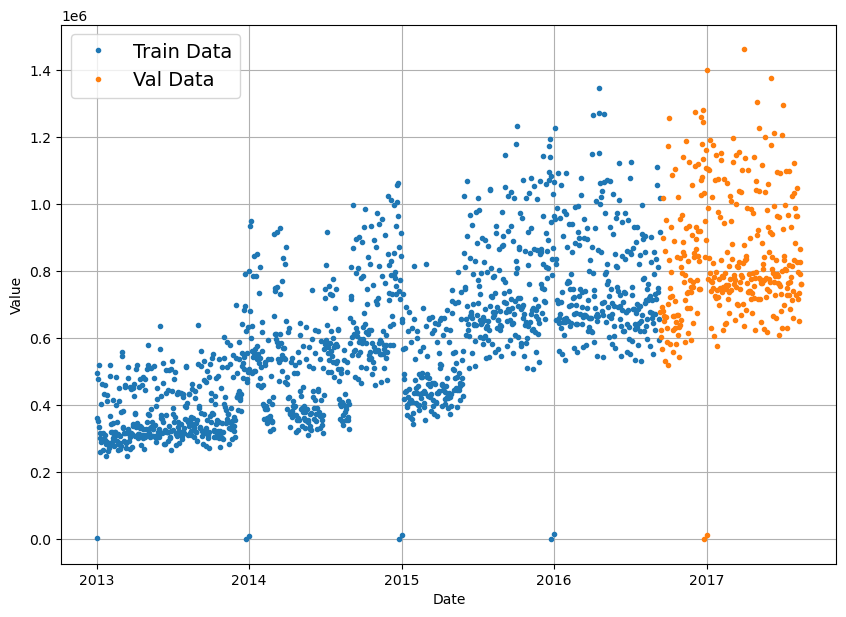

In [13]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train Data')
plot_time_series(timesteps=X_val, values=y_val, label='Val Data')

## Windowing the data

In [14]:
# function for getting the labelled windows
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=7, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels


In [15]:
WINDOW = 30
HORIZON = 5

In [16]:
values = df['value'].to_numpy()

In [17]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(1654, 1654)

In [18]:
for i in range(5):
  print(f"Window: {windows[i]} -> Label: {labels[i]}")

Window: [  2511.619 496092.4   361461.22  354459.7   477350.12  519695.4
 336122.8   318347.78  302530.8   258982.    289737.7   403258.22
 464638.56  293348.38  299129.56  318347.9   267498.53  296130.84
 432459.84  461092.38  311211.28  296214.72  283258.44  247245.69
 290022.78  413799.78  430412.    285460.16  264488.8   281061.12 ] -> Label: [271254.22 369402.06 518887.47 486336.8  344308.72]
Window: [496092.4  361461.22 354459.7  477350.12 519695.4  336122.8  318347.78
 302530.8  258982.   289737.7  403258.22 464638.56 293348.38 299129.56
 318347.9  267498.53 296130.84 432459.84 461092.38 311211.28 296214.72
 283258.44 247245.69 290022.78 413799.78 430412.   285460.16 264488.8
 281061.12 271254.22] -> Label: [369402.06 518887.47 486336.8  344308.72 321245.84]
Window: [361461.22 354459.7  477350.12 519695.4  336122.8  318347.78 302530.8
 258982.   289737.7  403258.22 464638.56 293348.38 299129.56 318347.9
 267498.53 296130.84 432459.84 461092.38 311211.28 296214.72 283258.44
 2472

## Train Test Splitting the Windows

In [19]:
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [20]:
train_windows, val_windows, train_labels, val_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(val_windows), len(train_labels), len(val_labels)

(1323, 331, 1323, 331)

## Metrics for evaluation

In [21]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae/mae_naive_no_season

# function for evaluating timeseries prediction
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
    'mae': mae.numpy(),
    'mse': mse.numpy(),
    'rmse': rmse.numpy(),
    'mape': mape.numpy(),
    'mase': mase.numpy()
  }

# Model building

## Function for making prediction with the model

In [22]:
# Function for making prediction with the model
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [23]:
import os

def create_model_checkpoint(model_name, save_path="model_checkpoints"):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_path, model_name),
    verbose=0,
    save_best_only=True
  )

In [24]:
# Block in NBEATS
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [25]:
# Parameters for the NBEATS Model
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

In [26]:
# Function to create nbeats model
def make_nbeats_model(window_size=8, horizon_size=1, model_name='nbeats'):
    WINDOW = window_size
    HORIZON = horizon_size

    INPUT_SIZE = WINDOW # called "Lookback" in Table 18
    THETA_SIZE = INPUT_SIZE + HORIZON

    tf.random.set_seed(7)
    np.random.seed(7)

    nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                     theta_size=THETA_SIZE,
                                     horizon=HORIZON,
                                     n_neurons=N_NEURONS,
                                     n_layers=N_LAYERS,
                                     name="InitialBlock")

    stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")


    backcast, forecast = nbeats_block_layer(stack_input)

    residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00") 

    # Stack of blocks
    for i, _ in enumerate(range(N_STACKS-1)):

      backcast, block_forecast = NBeatsBlock(
          input_size=INPUT_SIZE,
          theta_size=THETA_SIZE,
          horizon=HORIZON,
          n_neurons=N_NEURONS,
          n_layers=N_LAYERS,
          name=f"NBeatsBlock_{i}"
      )(residuals)

      residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}") 
      forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

    model = tf.keras.Model(inputs=stack_input, 
                             outputs=forecast, 
                             name=model_name)

    model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=["mae", "mse"])
    
    return model

# Model Training

In [27]:
model = make_nbeats_model(window_size=WINDOW, horizon_size=HORIZON, model_name='nbeats_window_30_horizon_10')

history = model.fit(x=train_windows,
            y=train_labels,
            epochs=N_EPOCHS,
            verbose=0,
            validation_data=(val_windows, val_labels),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 434: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 534: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [28]:
model.evaluate(val_windows, val_labels)

11/11 [==============================] - 0s 10ms/step - loss: 71272.2656 - mae: 71272.2656 - mse: 14772318208.0000


[71272.265625, 71272.265625, 14772318208.0]

In [29]:
model_preds = make_preds(model, val_windows)
model_preds[:5]

11/11 [==============================] - 1s 8ms/step


<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[598528.4 , 696460.6 , 899206.4 , 962053.7 , 734739.1 ],
       [679467.9 , 899043.94, 981201.25, 741229.2 , 683518.  ],
       [915464.7 , 975791.75, 709388.9 , 636301.25, 656223.25],
       [965122.3 , 710185.9 , 653086.5 , 662980.44, 580634.3 ],
       [722542.3 , 650099.  , 668838.2 , 587392.75, 646569.56]],
      dtype=float32)>

In [30]:
model_results = evaluate_preds(
  y_true = tf.squeeze(val_labels),
  y_pred = model_preds
)

model_results

{'mae': 71272.266,
 'mse': 14772318000.0,
 'rmse': 89839.19,
 'mape': 3343356000000.0,
 'mase': 5.094317}

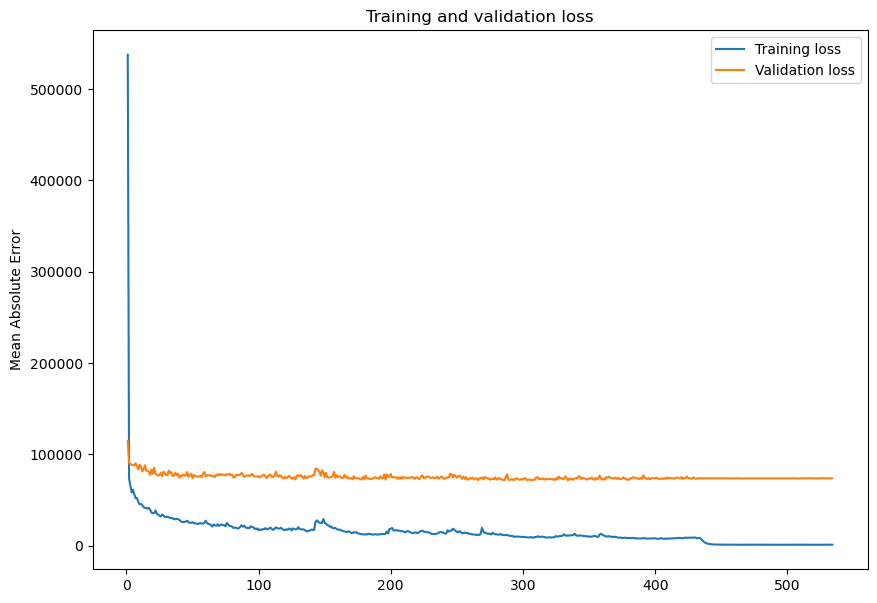

In [31]:
# visualize the loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

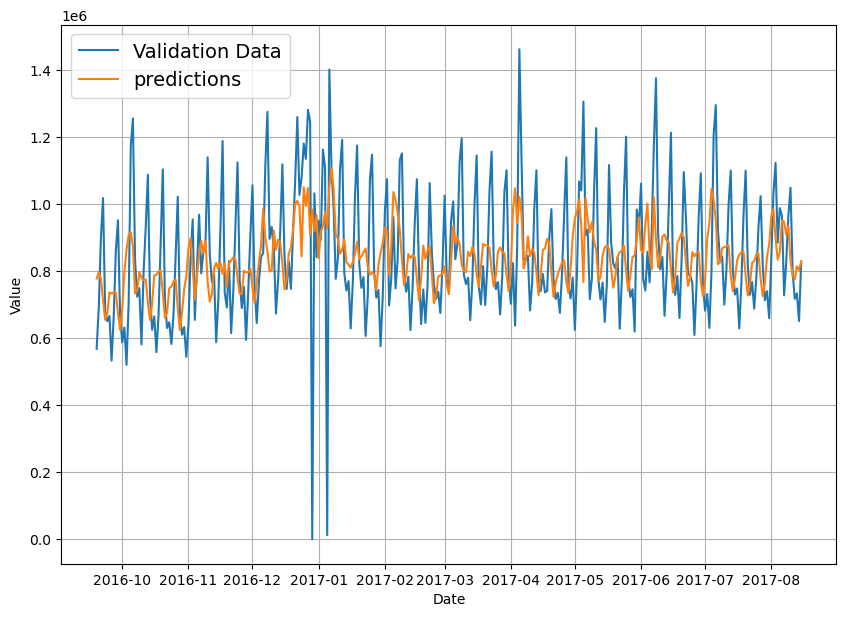

In [32]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_val[-len(val_windows):], values=val_labels[:, 0], format='-', label='Validation Data')
plot_time_series(timesteps=X_val[-len(val_windows):], values=tf.reduce_mean(model_preds, axis=1), format='-', label='predictions')